# GLLVM Longitudinal

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR # scheduler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


A Longitudinal GLLVM is a model with 1 variable per period for T periods, n observations, and p responses, and k covariates. We also have a random effect for each observation x response.

In [2]:
n = 10000
p = 13
q = 1
k = 3
T = 9

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)

In [3]:
response_types = {
    'binary': [0,1,2,3,4,5,6,7],
    'ordinal': [9, 10],
    'counts': [8, 11, 12]
}

response_types = {
    'binary': [0,1,2,3,4,5,6,7, 9, 10],
    'counts': [8, 11, 12]
}

link = {
    'binary' : lambda x: torch.logit(x),
    'ordinal': lambda x: torch.logit(x),
    'counts': lambda x: torch.log(x)
}


linkinv = {
    'binary': lambda x: 1/(1+torch.exp(-x)),
    'ordinal': lambda x: 1/(1+torch.exp(-x)),
    'counts': lambda x: torch.exp(x)
}

response_transform = {
    'binary' : lambda x: 2*x - 1,
    'ordinal': lambda x: 2*x - 1,
    'counts': lambda x: torch.log(x+1)
}



They can be of many response types. Here for the sake of illutration we will consider 3 response types: gaussian, binary, and poisson.

We allow for transformation of the data, which we account for in the estimation. In particular, Poisson data may be numerically problematic because their conditional expectation is the exponential of the linear predictor. Small differences in the latter can result in dramatic differences in the gradient. For instance, we can transform poisson with the following function $x \rightarrow \log(x+1)$. This transforms is needed in 2 places: for encoding, and at the loss function for computing the gradient.

## Computing the scale parameter

The scale parameter is computed in a second step (on the fit residual). They are updated at every iteration. This is not yet implemented.


### Modules

We need LongitudinalGLLVM as the overarching module, Sample which samples the data and takes additional arguments (such as nuisance parameters), Decoder which contains all the parameters of interest, and Encoder which encodes the data using a Neural Network.

### Design of the Encoder
Since the estimation problem for Z is the same at each time step, we model the encoder using a RNN. At each time step, the same encoder is used to compute the Z. At the same time, the hidden state of the RNN is used to predict the U variable, which is constant over time for each observation.

In [4]:
class LongitudinalGLLVM(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sample = Sample(self.decoder)
    
    def plot_cov(self, what="linpar", x=None):
        data_sample = self.sample(x=x)
        data =  data_sample[what].detach().view(n, -1).cpu().numpy()
        cov_matrix = np.cov(data, rowvar=False)

        plt.figure(figsize=(10,10))
        sns.heatmap(cov_matrix, annot=False, fmt='g')
        plt.show()
    
    def impute(self, x, y, mask, nsteps=10):
        """ Impute the missing values provided by the mask (True is missing) and return x imputed"""
        for _ in range(nsteps):
            z, u = self.encoder(x,y, transform_response = True)
            _, mean = self.decoder(x,z,u)
            y[mask] = mean[mask]
        return y

class Sample(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder
        self.phi = torch.ones(1).to(device) * .8
        self.var_u = torch.ones(1).to(device) * 1.0

    # sampling comes here
    
    def forward(self, x, n=None):
        with torch.no_grad():
            if x is None:
                Warning("x was set to None for sampling. X is usually fixed. Are you sure you want to sample x?")
                x = torch.randn((n, T, k)).to(device)
            
            n = x.shape[0]

            u = torch.randn((n, 1, p)).to(device) * torch.sqrt(self.var_u)
            d = torch.randn((n, T, q)).to(device)
            z = self.AR(d)

            linpar, mean = self.decoder(x, z, u) # decoder gives the expectation

            y = self.sample_response(mean)

            return {"x":x, "y":y, "z":z, "u":u, "linpar":linpar, "mean":mean}

    def sample_response(self, mean):
            y = torch.zeros_like(mean).to(device)
            for response_type, response_id in response_types.items():
                if response_type == "binary":
                    y[:,:,response_id] = torch.bernoulli(mean[:,:,response_id]).to(device)
                elif response_type == "ordinal":
                    cum_probs = mean[:,:,response_id]
                    # draw one uniform for the whole vector
                    random = torch.rand((*cum_probs.shape[0:2], 1)).to(device)
                    # compare with the cumulative probabilities
                    ordinal = torch.sum(random > cum_probs, dim=2)
                    ordinal = torch.nn.functional.one_hot(ordinal).squeeze().float()
                    ordinal = ordinal[:,:,1:] # discard the first column of the one_hot encoding, as it is superfluous (as a 0)
                    y[:,:,response_id] = ordinal
                elif response_type == "counts":
                    y[:,:,response_id] = torch.poisson(mean[:,:,response_id])
            return y

    def AR(self, d):
        z = d.clone()

        for t in range(1, z.shape[1]):
            z[:,t] = z[:,t] + z[:, t-1].clone() * self.phi  # we need to clone else the gradient wants to pass through it
        return z
                
    
class Decoder(nn.Module):
    # Yields the expectation
    def __init__(self):
        super().__init__()

        # decoder part (our parameters of interest)
        self.wz = nn.Parameter(torch.randn((q, p)) * .3)
        self.wx = nn.Parameter(torch.randn((1, k, p))* .3) # Measurement invariance!
        self.bias = nn.Parameter(torch.zeros((1, 1, p))* 2) # Measurement invariance!

    # decoding (computing the conditional mean)
    def forward(self, x, z, u):

        xwx = (x.unsqueeze(2) @ self.wx).squeeze() # see section "details of tensorproducts"
        zwz = (z.unsqueeze(2) @ self.wz).squeeze()
        # for the ordinal variables:
        linpar = self.bias + xwx + zwz + u 

        # Apply the inverse link to get the conditional expectation
        mean  = torch.zeros_like(linpar)
        for response_type, response_id in response_types.items():
            mean[:,:,response_id] = linkinv[response_type](linpar[:,:,response_id])
        # Transform the 
        return linpar, mean



class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder part
        # input dimension is (p+k) (responses + covariates)
        # output dimension is q+p (one latent )
        input_size = p + k
        hidden_size = (p + q) * 5
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
        )
        # fully connected layers for Z and U
        self.fc_Z = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = q),
        )

        self.fc_U = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features = p)
        )

        self.optimizer =  torch.optim.Adam(self.parameters(), lr=.01)
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=.95)
        self.loss = nn.MSELoss()

    
    def forward(self, x, y, transform_response = False):
        # Initialize hidden state

        # pass the input through the RNN
        if transform_response:
            y_transformed = torch.zeros_like(y)
            with torch.no_grad():
                for response_type, response_id in response_types.items():
                    y_transformed[:,:,response_id] = response_transform[response_type](y[:,:,response_id])
        else:
            y_transformed = y

        xy = torch.cat([x, y_transformed], dim=2)
        rnn_out, _ = self.rnn(xy)
        out = self.fc(rnn_out)
        z_pred = self.fc_Z(out)
        u_pred = self.fc_U(out[:, -1, :]).unsqueeze(1)
        return z_pred, u_pred
    
    def fit(self, x, y, z, u, epochs = 100, verbose = False):
        y = y.clone()
        with torch.no_grad():
            for response_type, response_id in response_types.items():
                y[:,:,response_id] = response_transform[response_type](y[:,:,response_id])
        # Fit the encoder
        for epoch in range(epochs):
            self.optimizer.zero_grad()

            z_pred, u_pred = self(x, y, transform_response = False)

            loss = self.loss(z_pred, z) + self.loss(u_pred, u)

            if verbose:
                print(f"\nEpoch {epoch}/{epochs}, loss={loss}")
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

        return loss
    
    def plot(self, x, y, z, u):
        with torch.no_grad():
            z_pred, u_pred = self(x, y, transform_response = True)

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

        ax1.scatter(z, z_pred)
        ax1.set_xlabel('Z True')
        ax1.set_ylabel('Z Pred')
        ax1.set_title('Encoded values of Z')
        ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", color="red")

        ax2.scatter(u, u_pred)
        ax2.set_xlabel('U True')
        ax2.set_ylabel('U Pred')
        ax2.set_title('Encoded values of U')
        ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", color="red")


        plt.show()
        


class MELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y, linpar, ys, linpars):
        """Computes the loss. hat is recontructed y, ys is simulated"""
        y_transformed = torch.zeros_like(y)
        ys_transformed = torch.zeros_like(ys)
        with torch.no_grad():
            for response_type, response_id in response_types.items():
                y_transformed[:,:,response_id] = response_transform[response_type](y[:,:,response_id])
                ys_transformed[:,:,response_id] = response_transform[response_type](ys[:,:,response_id])


        return -torch.mean(y_transformed* linpar - ys_transformed * linpars) * y.shape[1] * y.shape[2]
        # return torch.mean(torch.pow(y-linpar, 2) - torch.pow(ys - linpars, 2))
        # loss = torch.mean(y.T @ linpar - ys.T @linpars)/y.shape[0]
        # return loss


In [5]:
model_sample = LongitudinalGLLVM().to(device)
data_sample = model_sample.sample(x=None, n=n)
mask = torch.rand_like(data_sample['y']).to(device) < 0.0

In [6]:

model = LongitudinalGLLVM().to(device)
criterion = MELoss()
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=.1)
scheduler = StepLR(optimizer, step_size=10, gamma=.95)
mseLoss = nn.MSELoss()
epochs = 500



def compute_autocorr(z):
    # Compute the sample autocovariance and autocorrelation
    autocovariance = torch.mean((z[:, 1:] - torch.mean(z[:, 1:])) * (z[:, :-1] - torch.mean(z[:, :-1])), dim=1)
    autocorrelation = autocovariance / torch.var(z[:, :-1])

    # Estimate phi using the autocorrelation formula for AR(1)
    phi = torch.mean(autocorrelation)

    return phi

In [7]:
# create tensor dataset
losses = []
learning_rates = []
learning_rates_encoder = []
param_values = []

for epoch in range(1, epochs +1):
    optimizer.zero_grad()

    # impute and sample
    with torch.no_grad():
        # data_true["y"] = model.impute(data_true["x"], data_true["y"], mask=mask["y"], nsteps=5)
        # simulate data from the current parameter values, Unconditionally (!)
        data_sim = model.sample(x=data_sample["x"])
        data_sim['y'][mask] = 0.5
        
        assert torch.eq(data_sim["x"], data_sample["x"]).all().item()

        # compute the imputing values without the gradients
        zhat_sample, uhat_sample = model.encoder(data_sample["x"], data_sample["y"], transform_response=True)
        zhat_sim, uhat_sim = model.encoder(data_sim["x"], data_sim["y"], transform_response=True)


    # train the encoder on the simulated data
    encoder_loss = model.encoder.fit(data_sim["x"], data_sim["y"], data_sim["z"], data_sim["u"],  epochs= 5) 
    
    # compute the decoded value
    linpar_sample, mean_sample = model.decoder(data_sample["x"], zhat_sample, uhat_sample)
    linpar_sim, mean_sim = model.decoder(data_sim["x"], zhat_sim, uhat_sim)

    # # impute values
    # data_sample["y"] = model.impute(data_sample["x"], data_sample["y"], mask, nsteps=2)
    # data_sim["y"] = model.impute(data_sim["x"], data_sim["y"], mask, nsteps=2)

    # model.decoder.wz.grad = mygrad
    loss = criterion(data_sample["y"], linpar_sample,  data_sim["y"], linpar_sim)
    loss.backward()

    # Update nuisance parameters
    with torch.no_grad():
        model.sample.var_u = .8* model.sample.var_u + .2 * torch.var(uhat_sample) * (model.sample.var_u / torch.var(uhat_sim))
        model.sample.phi = .8 * model.sample.phi + .2 * compute_autocorr(zhat_sample) * model.sample.phi / compute_autocorr(zhat_sim)
        if model.sample.phi > .9:
            model.sample.phi = torch.ones(1) * .9 
        # model.sample.phi = zhat_sample[:,1:,:] - zhat_sample[:,:-1,:]
        print(f'var_u: {model.sample.var_u}, phi: {model.sample.phi}')


    with torch.no_grad():   
        fit = mseLoss(mean_sample, data_sample["y"])


    optimizer.step()
    scheduler.step()

    losses.append(fit.item())
    learning_rates.append(optimizer.param_groups[0]['lr'])
    learning_rates_encoder.append(model.encoder.optimizer.param_groups[0]['lr'])
    param_values.append(model.decoder.wz.clone().detach())

    print(f"\nEpoch {epoch}/{epochs}, loss_fit = {fit.item():.2f}, encoder_loss = {encoder_loss.item():.2f}.")

var_u: tensor([1.0003], device='cuda:0'), phi: tensor([0.7692], device='cuda:0')

Epoch 1/500, loss_fit = 3.12, encoder_loss = 4.43.
var_u: tensor([0.9885], device='cuda:0'), phi: tensor([0.7614], device='cuda:0')

Epoch 2/500, loss_fit = 2.91, encoder_loss = 2.84.
var_u: tensor([0.9730], device='cuda:0'), phi: tensor([0.7416], device='cuda:0')

Epoch 3/500, loss_fit = 2.95, encoder_loss = 2.80.
var_u: tensor([0.9588], device='cuda:0'), phi: tensor([0.7346], device='cuda:0')

Epoch 4/500, loss_fit = 2.73, encoder_loss = 2.49.
var_u: tensor([0.9584], device='cuda:0'), phi: tensor([0.7335], device='cuda:0')

Epoch 5/500, loss_fit = 2.50, encoder_loss = 2.36.
var_u: tensor([0.9596], device='cuda:0'), phi: tensor([0.7327], device='cuda:0')

Epoch 6/500, loss_fit = 2.45, encoder_loss = 2.33.
var_u: tensor([0.9586], device='cuda:0'), phi: tensor([0.7341], device='cuda:0')

Epoch 7/500, loss_fit = 2.29, encoder_loss = 2.34.
var_u: tensor([0.9596], device='cuda:0'), phi: tensor([0.7329], devic

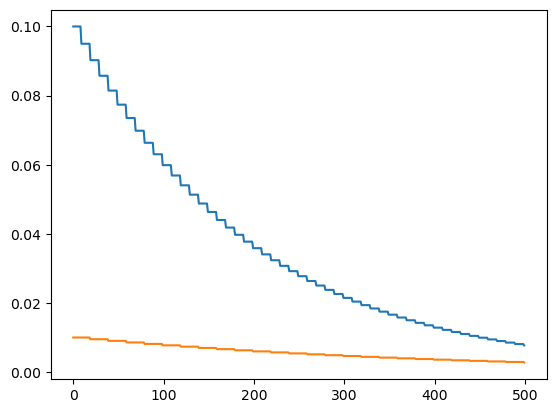

In [12]:
plt.plot(learning_rates)
plt.plot(learning_rates_encoder)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


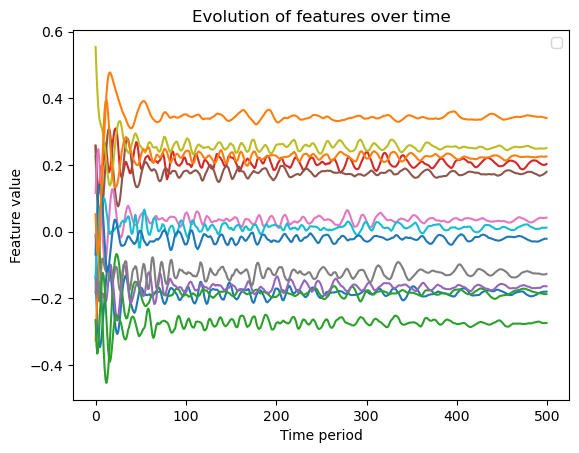

In [13]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in param_values], axis=0)


# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i])

# Add legend and labels
ax.legend()
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()


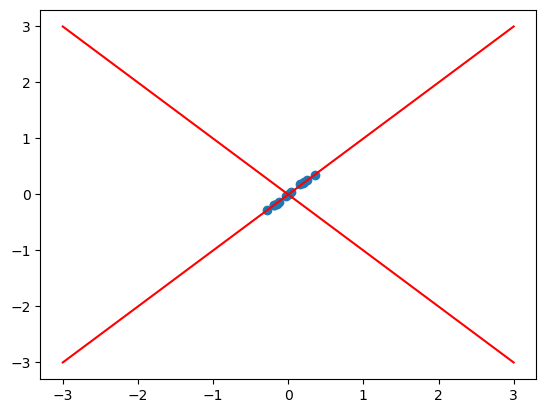

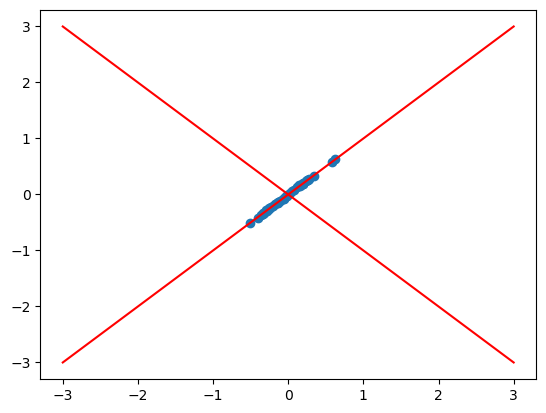

In [14]:
plt.scatter(model_sample.decoder.wz.detach().cpu().numpy(), model.decoder.wz.detach().cpu().numpy())
plt.plot([-3,3], [-3,3], color="red")
plt.plot([-3,3], [3,-3], color="red")
plt.show()

plt.scatter(model_sample.decoder.wx.detach().cpu().numpy(), model.decoder.wx.detach().cpu().numpy())
plt.plot([-3,3], [-3,3], color="red")
plt.plot([-3,3], [3,-3], color="red")
plt.show()

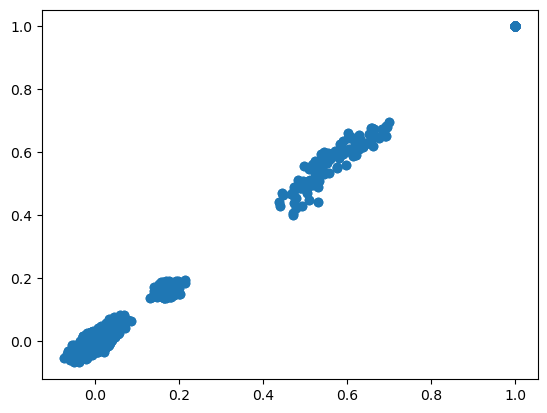

In [15]:
dat1 = torch.reshape(model_sample.sample(x=data_sample['x'])['y'].detach().cpu(), (data_sample['y'].shape[0], -1))
cor1 = np.corrcoef(dat1, rowvar=False)
dat2 = torch.reshape(model.sample(x=data_sample['x'])['y'].detach().cpu(), (data_sample['y'].shape[0], -1))
cor2 = np.corrcoef(dat2, rowvar=False)

plt.scatter(cor1, cor2)
plt.show()